<h1 style="text-align: center;">Data Science Project</h1>
<h2 style="text-align: center;">Hotel Booking Demand Dataset</h2>

## Contents:
> **Section A:** EDA of Hotel Bookings and ML to Predict Cancellations
>> 1. Getting the Data
>> 2. Understanding and Visualizing the Data
>> 3. Data Cleaning
>> 4. Training and Evaluating Models
>> 5. Evaluating the Test Set
>
> **Section B:** Using Different ML Techniques to Improve Prediction Results
>> Model Improvements:
6. First Attempt: Fine-Tune the Random Forest model.
7. Second Attempt: Fine-Tune the KNN model.
8. Third Attempt: Train and Tune a Logistic Regression model.
9. Fourth Attempt: Train and Tune a Gradient Boosting model.
10. Fifth Attempt: Train Voting Classifiers using the Tuned Models.
11. Sixth Attempt: Use the Tuned Models for Stacking.
12. Re-evaluating the Test Set

***Note: If you already read the first section, you may want to skip directly to Section B.***

In [1]:
# common imports
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier, DMatrix, cv
from sklearn import clone  # 'clone' constructs a new unfitted estimator with the same parameters

# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

## Section A: EDA of Hotel Bookings and ML to Predict Cancellations

<a id="one"></a>

# 1. Getting the Data

In [2]:
# read the csv file
df = pd.read_csv(r"hotel_bookings.csv")

In [3]:
# display the first 5 rows for a quick look
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# DataFrame shape (rows, columns)
# understand the amount of data we are working with
df.shape

(119390, 32)

In [5]:
# description of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

> In a first observation it is clear that some features have
> missing values (i.e. "company" and "agent" columns).
> We will need to take care of this later.

In [6]:
# summary of the numerical attributes
# null values are ignored
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


> ### Features in the DataFrame:
>> 1. hotel: Resort Hotel or City Hotel
>> 2. is_canceled: Value indicating if the booking was canceled (1) or not (0)
>> 3. lead_time: Number of days between the booking date to the arrival date
>> 4. arrival_date_year: Year of arrival
>> 5. arrival_date_month: Month of arrival
>> 6. arrival_date_week_number: Week number according to year of arrival
>> 7. arrival_date_day_of_month: Day of arrival
>> 8. stays_in_weekend_nights: Number of weekend nights booked (Saturday or Sunday)
>> 9. stays_in_week_nights: Number of week nights booked (Monday to Friday)
>> 10. adults: Number of adults
>> 11. children: Number of children
>> 12. babies: Number of babies
>> 13. meal: Type of meal booked
>> 14. country: Country of origin
>> 15. market_segment: Market segment designation, typically influences the price sensitivity
>> 16. distribution_channel: Booking distribution channel, refers to how the booking was made
>> 17. is_repeated_guest: Value indication if the booking was from a repeated guest (1) or not (0)
>> 18. previous_cancellations: Number of previous cancellations prior to current booking
>> 19. previous_bookings_not_canceled: Number of previous booking not canceled prior to current booking
>> 20. reserved_room_type: Code of room type reserved
>> 21. assigned_room_type: Code for the type of room assigned to the booking
>> 22. booking_changes: Number of changes made to the booking since entering the hotel management system
>> 23. deposit_type: Type of deposit made for the reservation
>> 24. agent: ID of the travel agency that made the booking
>> 25. company: ID of the company/organization that made the booking or is responsible for payment
>> 26. days_in_waiting_list: Number of days booking was in the waiting list until it was confirmed
>> 27. customer_type: Type of booking
>> 28. adr: Average Daily Rate (the sum of transactions divided by the number of nights stayed)
>> 29. required_car_parking_spaces: Number of car parking spaces requested
>> 30. total_of_special_requests: Number of special requests made by the customer
>> 31. reservation_status: Last reservation status (Canceled, Check-Out, No-Show)
>> 32. reservation_status_date: Date at which the last status was set
>>
>>> ##### *Understanding the features could help gain insight on how to treat null values.*

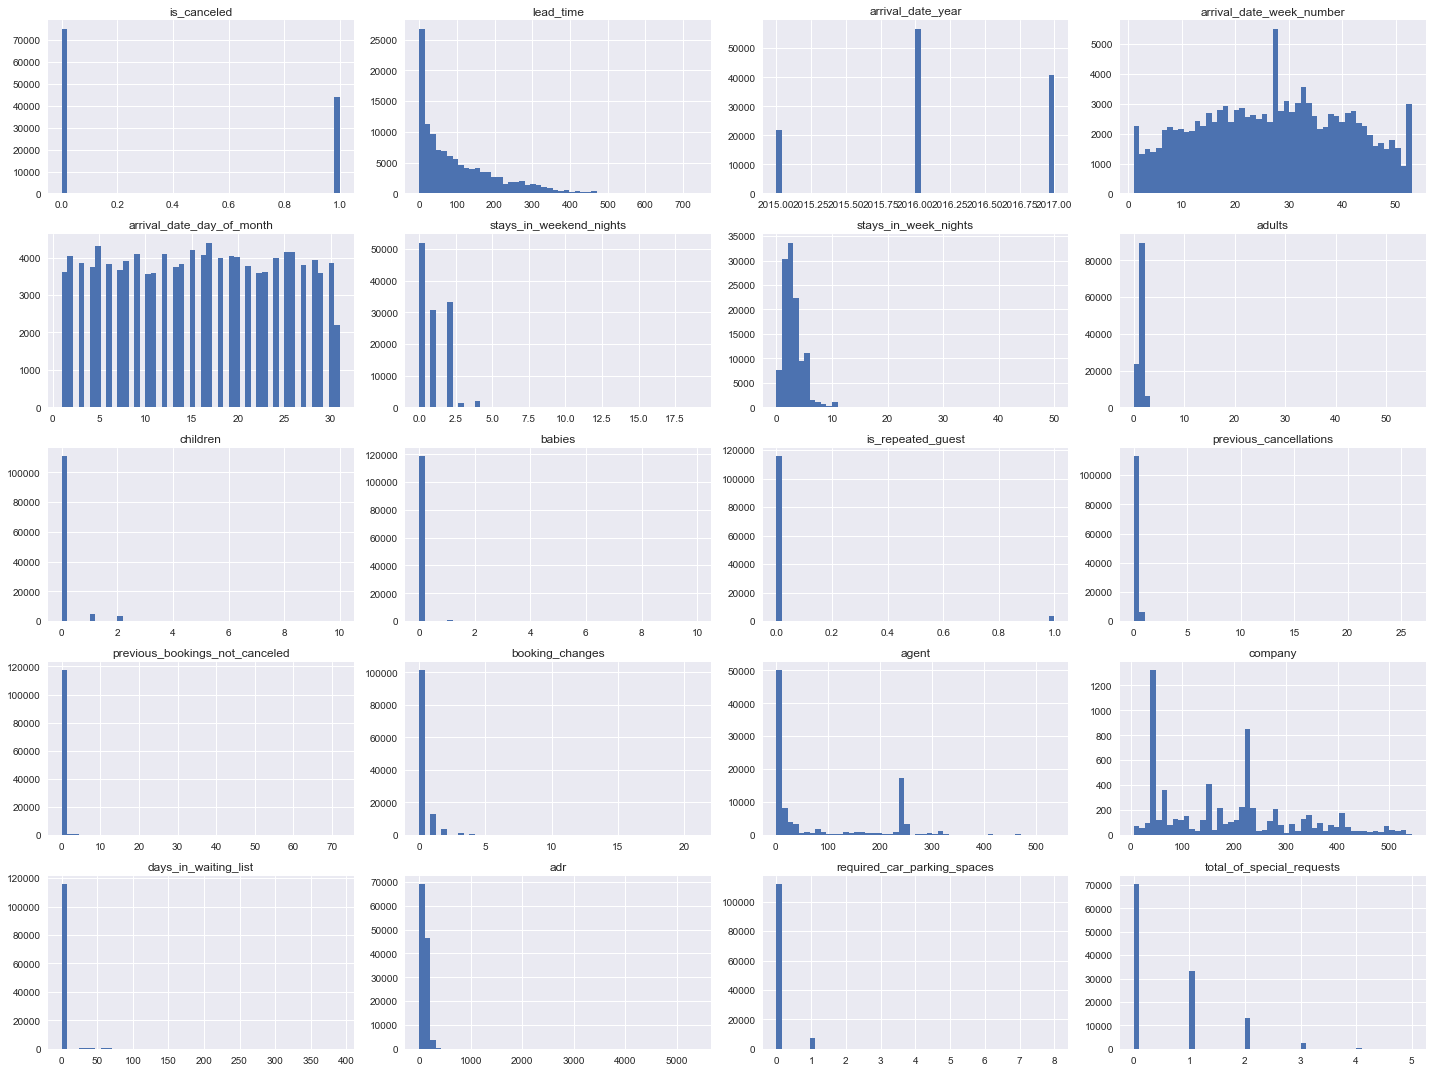

In [7]:
# a histogram plot for each numerical attribute
df.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
>> 1. Some weeks have more bookings. This could be because of holiday or summer seasons, when people tend to travel more.
>> 2. According to the lead_time plot, most bookings were made shortly before arrival.
>> 3. Bookings tend to be without children or babies.
>> 4. It seems that the most accommodations are two weeks long or shorter.
>> 5. While most bookings were not canceled, there are thousands of instances that were.

> # Objective
> ## Predicting if a booking will be canceled.
>> ### Chosen Feature:
>> #### *is_canceled* column
>>> 0 means the booking was not canceled
>>>
>>> 1 means the booking was canceled
>> ### Motive:
>> Like any business, hotels are also looking to gain profit. A model that predicts if the booking
>> is likely to be canceled could be a good indication for hotels, as they
>> may prefer to accept the lower risk bookings first.

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [8]:
# use Scikit-learn train_test_split function to split the data
# the reason for selecting 0.15 as the test size is because the dataset is very large
# the random state parameter ensures that data will be shuffled and split the same way in each run
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

In [9]:
print("Number of instances in training set: ", len(train_set))
print("Number of instances in testing set: ", len(test_set))

Number of instances in training set:  101481
Number of instances in testing set:  17909


<a id="two"></a>

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [10]:
# deep copy of the training set
df2 = train_set.copy()

In [11]:
df2.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
24840,Resort Hotel,0,156,2016,May,23,30,1,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,241.0,NaN,0,Transient,52.36,0,1,Check-Out,2016-06-05
6904,Resort Hotel,0,292,2016,July,29,10,1,0,2,0.0,0,BB,ISR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,72.90,1,2,Check-Out,2016-07-11


In [12]:
df2.is_canceled.value_counts()

0    64049
1    37432
Name: is_canceled, dtype: int64

> ### Missing Features:

In [13]:
# the methods below calculate the number of missing values
missing_values = df2.isna().sum()
missing_values = missing_values[missing_values != 0]
missing_values

children        4
country       396
agent       13851
company     95711
dtype: int64

In [14]:
# replace missing values

# can assume that there were no children
df2.fillna({"children": 0}, inplace=True)

# missing countries can be labeled unknown
df2.fillna({"country": "Unknown"}, inplace=True)

# missing agent ID can be zero, presuming the booking was made privately
df2.fillna({"agent": 0}, inplace=True)

# missing company ID can be zero (for the same reason as agent ID)
df2.fillna({"company": 0}, inplace=True)

In [15]:
# check that the values were filled
df2.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

> ### Numerical Attributes:

In [16]:
# method creates a correlations matrix
corr_matrix = df2.corr()

In [17]:
# looking at attributes correlation with is_canceled feature
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.292182
previous_cancellations            0.109883
adults                            0.059744
days_in_waiting_list              0.053068
adr                               0.046790
stays_in_week_nights              0.027764
arrival_date_year                 0.017365
arrival_date_week_number          0.007757
children                          0.006771
stays_in_weekend_nights          -0.000019
arrival_date_day_of_month        -0.006062
babies                           -0.034658
agent                            -0.046444
previous_bookings_not_canceled   -0.055847
company                          -0.082484
is_repeated_guest                -0.084179
booking_changes                  -0.142916
required_car_parking_spaces      -0.195675
total_of_special_requests        -0.233580
Name: is_canceled, dtype: float64

In [18]:
# experimenting with attribute combinations

# create a column with total amount of guests
df2["guests_stayed"] = df2["adults"] + df2["children"] + df2["babies"]

# create a column with total nights booked
df2["nights_stayed"] = df2["stays_in_week_nights"] + df2["stays_in_weekend_nights"]

In [19]:
# looking at the correlation matrix again with the added columns
corr_matrix = df2.corr()
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.292182
previous_cancellations            0.109883
adults                            0.059744
days_in_waiting_list              0.053068
adr                               0.046790
guests_stayed                     0.046693
stays_in_week_nights              0.027764
nights_stayed                     0.020709
arrival_date_year                 0.017365
arrival_date_week_number          0.007757
children                          0.006771
stays_in_weekend_nights          -0.000019
arrival_date_day_of_month        -0.006062
babies                           -0.034658
agent                            -0.046444
previous_bookings_not_canceled   -0.055847
company                          -0.082484
is_repeated_guest                -0.084179
booking_changes                  -0.142916
required_car_parking_spaces      -0.195675
total_of_special_requests        -0.233580
Name: is_canceled, dtype: float64

> ### Correlations with is_canceled Attribute - Overview:
>> The strongest positive correlations (0.1 or more) are:
>> * lead_time
>> * previous_cancellations
>>
>> The strongest negative correlations (-0.1 or less) are:
>> * total_of_special_requests
>> * required_car_parking_spaces
>> * booking_changes
>>
> The attribute combinations tested (guests stayed and nights stayed) both had weak correlations.

> ### Cancellations According to Lead Time

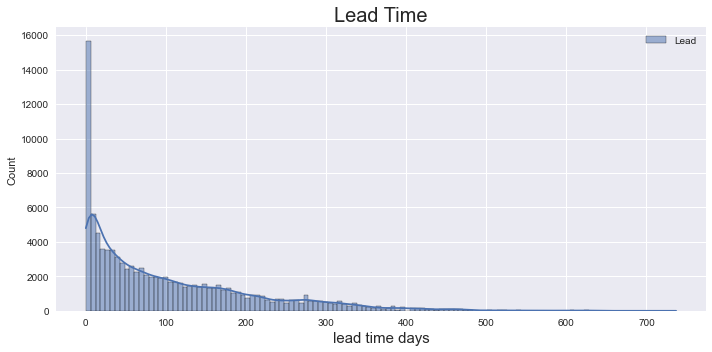

In [20]:
# hist plot of lead time
# kde = kernel density estimation (displays distribution function, density curve)
# shows the distribution and highest concentration points
plt.figure(figsize=(10, 5))
lead_time = df2['lead_time']
lead_time = pd.DataFrame(sorted(lead_time, reverse=True), columns=['Lead'])
sns.histplot(lead_time, kde=True)
plt.title("Lead Time", size=20)
plt.xlabel("lead time days", size=15)
plt.tight_layout()
plt.show()

In [21]:
# divides lead time by less than 100 days, 100-355 days and 365 or more days
lead_time_1 = df2[df2["lead_time"] < 100]
lead_time_2 = df2[(df2["lead_time"] >= 100) & (df2["lead_time"] < 365)]
lead_time_3 = df2[df2["lead_time"] >= 365]

In [22]:
# calculates cancellations according to lead time groups
lead_cancel_1 = lead_time_1["is_canceled"].value_counts()
lead_cancel_2 = lead_time_2["is_canceled"].value_counts()
lead_cancel_3 = lead_time_3["is_canceled"].value_counts()

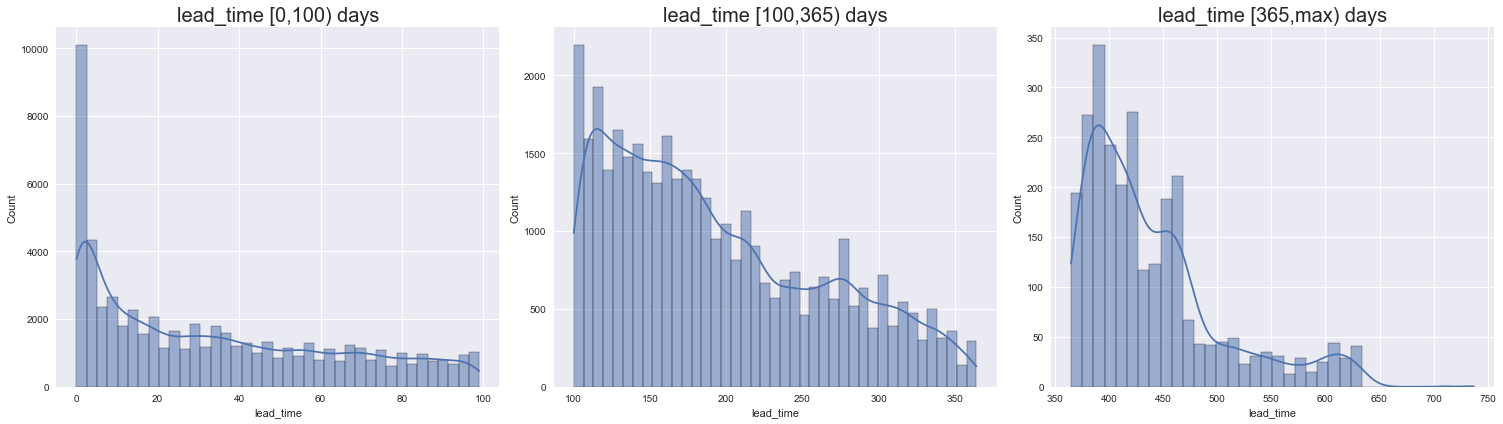

In [23]:
# hist plot for each lead time group
fig, (bx1, bx2, bx3) = plt.subplots(1, 3, figsize=(21, 6))
sns.histplot(lead_time_1["lead_time"], ax=bx1, kde=True)
bx1.set_title("lead_time [0,100) days", size=20)
sns.histplot(lead_time_2["lead_time"], ax=bx2, kde=True)
bx2.set_title("lead_time [100,365) days", size=20)
sns.histplot(lead_time_3["lead_time"], ax=bx3, kde=True)
bx3.set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

In [24]:
# total count of lead time according to cancellation
total_lead_days_cancel = pd.DataFrame(data=[lead_cancel_1, lead_cancel_2, lead_cancel_3],
                                      index=["[0,100) days", "[100,365) days", "[365,max) days"])
total_lead_days_cancel

,0,1
"[0,100) days",44163,16828
"[100,365) days",19013,18746
"[365,max) days",873,1858


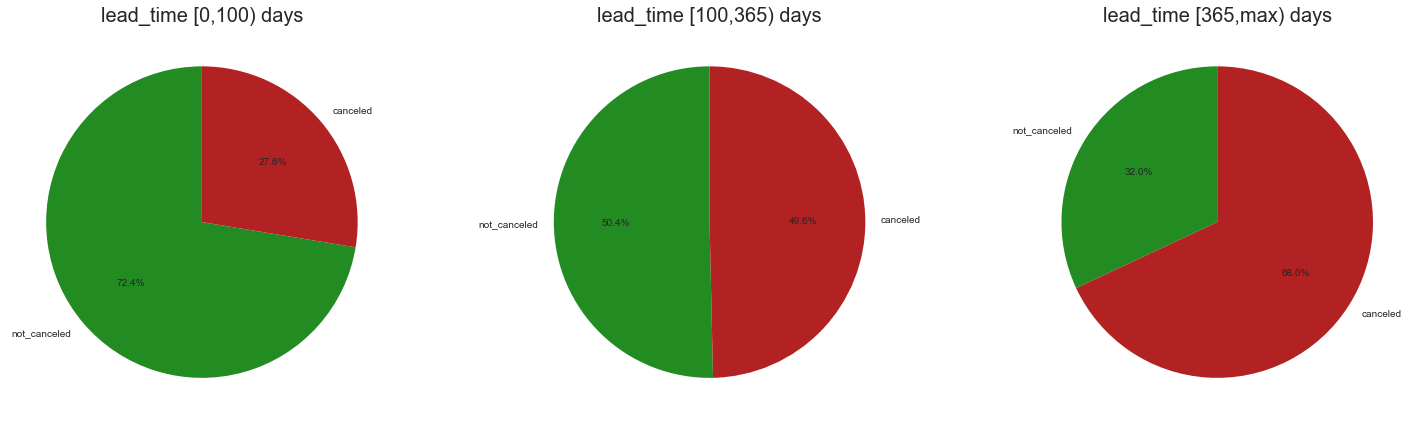

In [25]:
# pie plot for each lead time group
fig, ax = plt.subplots(1, 3, figsize=(21, 6))
ax[0].pie(np.array([total_lead_days_cancel[0][0], total_lead_days_cancel[1][0]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90,
          colors=['forestgreen', 'firebrick'])
ax[0].set_title("lead_time [0,100) days", size=20)
ax[1].pie(np.array([total_lead_days_cancel[0][1], total_lead_days_cancel[1][1]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90,
          colors=['forestgreen', 'firebrick'])
ax[1].set_title("lead_time [100,365) days", size=20)
ax[2].pie(np.array([total_lead_days_cancel[0][2], total_lead_days_cancel[1][2]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90,
          colors=['forestgreen', 'firebrick'])
ax[2].set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

> #### Observations:
>> * Most bookings occur about 5 days prior to arrival.
>> * When the lead time is larger the chances for cancellation increase.
>> * The amount of bookings is steady overall between 20-100 days, then drops.

> ### Cancellations According to Previous Cancellations

In [26]:
# get previous cancellations column
prev_cancel = df2["previous_cancellations"]

In [27]:
# sort the index values
prev_cancel.value_counts().sort_index()

0     96001
1      5112
2       101
3        48
4        29
5        15
6        22
11       30
13        8
14       11
19       17
21        1
24       45
25       20
26       21
Name: previous_cancellations, dtype: int64

In [28]:
print("Cancellation Rates:\n")
print('Never canceled =', str(round(df2[df2['previous_cancellations'] == 0]
                                    ['is_canceled'].mean() * 100, 2)) + ' %')
print('Canceled once =', str(round(df2[df2['previous_cancellations'] == 1]
                                   ['is_canceled'].mean() * 100, 2)) + ' %')
print('Canceled more than 10 times:', str(round(df2[df2['previous_cancellations'] > 10]
                                                ['is_canceled'].mean() * 100, 2)) + ' %')
print('Canceled more than 11 times:', str(round(df2[df2['previous_cancellations'] > 11]
                                                ['is_canceled'].mean() * 100, 2)) + ' %')

Cancellation Rates:

Never canceled = 33.76 %
Canceled once = 94.37 %
Canceled more than 10 times: 85.62 %
Canceled more than 11 times: 99.19 %


In [29]:
# create a list with previous cancellations indices
prev_cancel_index = df2["previous_cancellations"].value_counts().index.to_list()
# sort the list
prev_cancel_index.sort()

# calculate the average percentage of cancellations for each value in the DataFrame
percentage_prev_cancel = []
for i in prev_cancel_index:
    percentage_prev_cancel.append((round(df2[df2["previous_cancellations"] == i]["is_canceled"].mean() * 100, 2)))

In [30]:
# create a DataFrame with the results
df_prev_cancel = pd.DataFrame(percentage_prev_cancel, index=prev_cancel_index, columns=["Previous Cancellations %"])
df_prev_cancel

,Previous Cancellations %
0,33.76
1,94.37
2,33.66
3,29.17
4,24.14
5,13.33
6,31.82
11,30.00
13,87.50
14,100.00


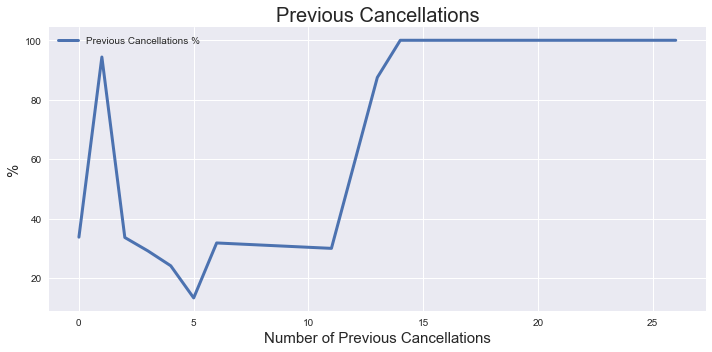

In [31]:
# plot previous cancellations by percentages
df_prev_cancel.plot(figsize=(10, 5), linewidth=3)
plt.title("Previous Cancellations", size=20)
plt.xlabel("Number of Previous Cancellations", size=15)
plt.ylabel("%", size=15)
plt.tight_layout()
plt.show()

> ### Observations:
>> The percentages show that when there are more previous cancellations, there is
>> a substantially higher chance the customer will cancel again.

> ### Cancellations According to Total of Special Requests

In [32]:
# number of instances for each value
df2["total_of_special_requests"].value_counts()

0    59677
1    28355
2    11017
3     2120
4      279
5       33
Name: total_of_special_requests, dtype: int64

In [33]:
# group by cancellations
is_canceled = df2.groupby(by="is_canceled")

In [34]:
# get groups according to binary outcome
canceled = is_canceled.get_group(1)
not_canceled = is_canceled.get_group(0)

In [35]:
# count values for each outcome
special_requests_0 = not_canceled["total_of_special_requests"].value_counts()
special_requests_1 = canceled["total_of_special_requests"].value_counts()

In [36]:
# create a DataFrame for each outcome
df_special_requests_0 = pd.DataFrame(special_requests_0.values, index=special_requests_0.index,
                                     columns=["not_canceled"])
df_special_requests_1 = pd.DataFrame(special_requests_1.values, index=special_requests_1.index, columns=["canceled"])

In [37]:
# join both DataFrames side by side
df_special_requests = df_special_requests_0.join(df_special_requests_1)

In [38]:
# add total of both outcomes
special_requests_total = df_special_requests["not_canceled"] + df_special_requests["canceled"]

# calculate percentage of cancellations for each number of requests value individually
special_requests_percentage = []
for i in special_requests_total.index:
    special_requests_percentage.append(round((special_requests_1[i] / special_requests_total[i]) * 100, 2))
special_requests_percentage

[47.53, 21.97, 22.05, 17.88, 10.39, 6.06]

In [39]:
# add percentages as new column in DataFrame
df_special_requests.join(pd.DataFrame(special_requests_percentage, index=df_special_requests.index,
                                      columns=["cancellations %"]))

,not_canceled,canceled,cancellations %
0,31313,28364,47.53
1,22126,6229,21.97
2,8588,2429,22.05
3,1741,379,17.88
4,250,29,10.39
5,31,2,6.06


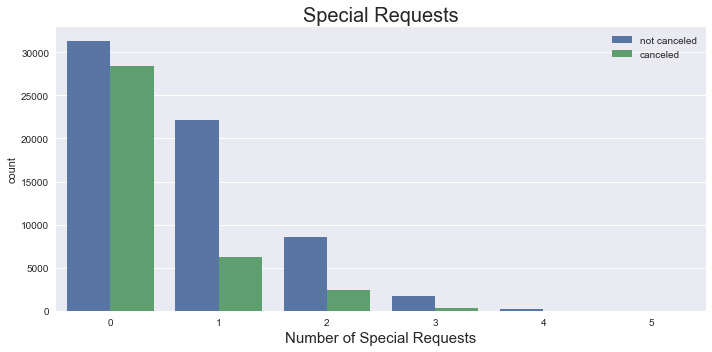

In [40]:
# plot special requests according to cancellations
plt.figure(figsize=(10, 5))
sns.countplot(x=df2["total_of_special_requests"], hue=df2["is_canceled"])
plt.title("Special Requests", size=20)
plt.xlabel("Number of Special Requests", size=15)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

> ### Observations:
>> * Nearly half of the bookings without special requests are canceled.
>> * There are fewer cancellations when the number of special requests increases.

> ### Cancellations According to Required Car Parking Spaces

In [41]:
# number of instances for each value
df2["required_car_parking_spaces"].value_counts().sort_index()

0    95114
1     6337
2       26
3        2
8        2
Name: required_car_parking_spaces, dtype: int64

In [42]:
# count values for each outcome with previous groupby
parking_spaces_0 = not_canceled["required_car_parking_spaces"].value_counts()
parking_spaces_1 = canceled["required_car_parking_spaces"].value_counts()

In [43]:
# value counts for non canceled instances
parking_spaces_0.sort_index()

0    57682
1     6337
2       26
3        2
8        2
Name: required_car_parking_spaces, dtype: int64

In [44]:
# value counts for canceled instances
parking_spaces_1

0    37432
Name: required_car_parking_spaces, dtype: int64

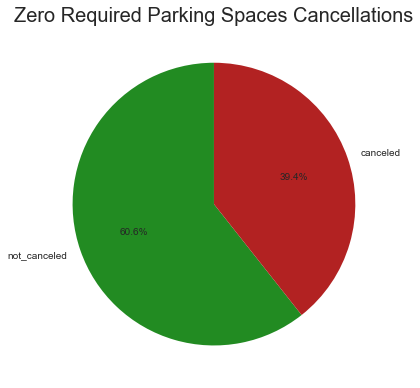

In [45]:
# pie plot of cancellations with zero required parking spaces
plt.pie(x=[parking_spaces_0[0], parking_spaces_1[0]], labels=["not_canceled", "canceled"], autopct='%1.1f%%',
        startangle=90, colors=['forestgreen', 'firebrick'])
plt.title("Zero Required Parking Spaces Cancellations", size=20)
plt.tight_layout()
plt.show()

> ### Observations:
>> * Dividing the instances into groups according to cancellations shows that canceled
>> bookings were only ones without required parking spaces.
>> * This could potentially be a bad indication for cancellations. The model could learn
>> that a booking can be canceled **only** if no parking spaces were required, which does not
>> necessarily have to be the case.

> ### Cancellations According to Booking Changes

In [46]:
# number of instances for each value
df2["booking_changes"].value_counts().sort_index()

0     86077
1     10809
2      3256
3       793
4       314
5        99
6        60
7        28
8        14
9         6
10        5
11        2
12        2
13        3
14        4
15        3
16        2
17        1
18        1
20        1
21        1
Name: booking_changes, dtype: int64

In [47]:
# count values for each outcome with previous groupby
booking_changes_0 = not_canceled["booking_changes"].value_counts()
booking_changes_1 = canceled["booking_changes"].value_counts()

In [48]:
# count index of not canceled
len(booking_changes_0.index)

21

In [49]:
# count index of canceled
len(booking_changes_1.index)

12

In [50]:
# fill missing values
# the outcome 0 has more values
# filling the values will enable joining the dataframes later
df_booking_changes_1 = pd.DataFrame(booking_changes_1, index=booking_changes_0.index)
df_booking_changes_1.fillna({"booking_changes": 0}, inplace=True)
booking_changes_1 = pd.Series(df_booking_changes_1["booking_changes"])

In [51]:
# add total of both outcomes
booking_changes_total = booking_changes_0 + booking_changes_1

# calculate percentage of cancellations for each number of booking changes individually
percentage_booking_changes = []
for i in booking_changes_total.index:
    percentage_booking_changes.append(round((booking_changes_1[i] / booking_changes_total[i]) * 100, 2))

In [52]:
# create a DataFrame with the percentage of cancellations
df_percentage_booking_changes = pd.DataFrame(percentage_booking_changes, index=booking_changes_total.index,
                                             columns=["cancellations %"])

In [53]:
# create a DataFrame for each outcome
df_booking_changes_0 = pd.DataFrame(booking_changes_0.values, index=booking_changes_0.index, columns=["not_canceled"])
df_booking_changes_1 = pd.DataFrame(booking_changes_1.values, index=booking_changes_1.index, columns=["canceled"])

In [54]:
# join all three DataFrames side by side
df_booking_changes = df_booking_changes_0.join([df_booking_changes_1, df_percentage_booking_changes])

# remove rows with 0% cancellations
df_booking_changes = df_booking_changes[df_booking_changes["cancellations %"] != 0]
df_booking_changes

,not_canceled,canceled,cancellations %
0,51065,35012.0,40.68
1,9272,1537.0,14.22
2,2599,657.0,20.18
3,668,125.0,15.76
4,257,57.0,18.15
5,81,18.0,18.18
6,43,17.0,28.33
7,26,2.0,7.14
8,10,4.0,28.57
10,4,1.0,20.00


> ### Observations:
>> * While a large amount of bookings with no changes were canceled, this category can change overtime
>> which could possibly be a source of leakage.

> ### Understanding the ADR Feature
>> Since this feature is not entirely clear from the description on Kaggle,
>> I've decided to further assess it.
>>
>> The Average Daily Rate (ADR) is typically calculated by taking the average revenue
>> earned from the rooms and dividing by the number of rooms sold (excluding rooms occupied
>> by staff).
>>
>> Since it is not clear if an ADR of zero indicates that the booking was canceled or
>> if the hotel did not gain profit, I will look at instances listed with an ADR
>> of zero. This should provide enough insight to see if this feature should be removed
>> during before model evaluations.

In [55]:
df2[df2["adr"] == 0]["reservation_status"].value_counts()

Check-Out    1514
Canceled      160
No-Show        26
Name: reservation_status, dtype: int64

In [56]:
df2[df2["adr"] == 0]["is_canceled"].value_counts()

0    1514
1     186
Name: is_canceled, dtype: int64

> ### Observations:
>> * Most bookings are labeled as checked-out and not canceled when the ADR was zero.
>> This concludes the previous speculation.

> ### Categorical Attributes:

> ### Cancellations According to Hotels and Arrival Month

In [57]:
df2["hotel"].value_counts()

City Hotel      67539
Resort Hotel    33942
Name: hotel, dtype: int64

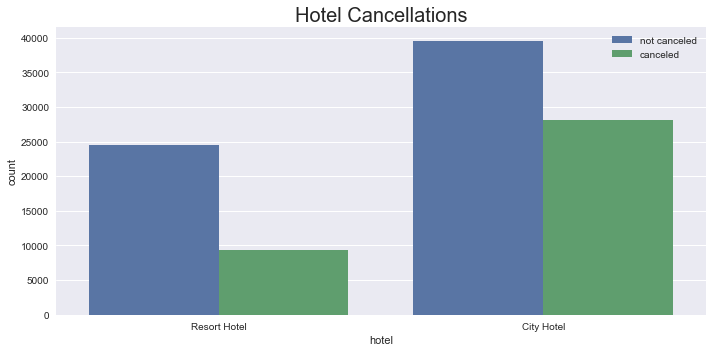

In [58]:
# a plot of the number of instances for each hotel according to cancellations
plt.figure(figsize=(10, 5))
sns.countplot(x=df2["hotel"], hue=df2["is_canceled"])
plt.title("Hotel Cancellations", size=20)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

In [59]:
ordered_months = ["January", "February", "March", "April", "May", "June",
                  "July", "August", "September", "October", "November", "December"]

resort_canceled_percent = []
city_canceled_percent = []

# divide cancellation outcome by hotel and month of arrival
resort_1 = canceled[canceled["hotel"] == "Resort Hotel"]["arrival_date_month"].value_counts()
resort_0 = not_canceled[not_canceled["hotel"] == "Resort Hotel"]["arrival_date_month"].value_counts()
city_1 = canceled[canceled["hotel"] == "City Hotel"]["arrival_date_month"].value_counts()
city_0 = not_canceled[not_canceled["hotel"] == "City Hotel"]["arrival_date_month"].value_counts()

# calculate cancellation percentage according to hotel
for i in ordered_months:
    resort_canceled_percent.append(round((resort_1[i] / (resort_0[i] + resort_1[i])) * 100, 2))
    city_canceled_percent.append(round((city_1[i] / (city_0[i] + city_1[i])) * 100, 2))

# create a DataFrame with the cancellation percentage of each hotel
df_resort_cancel = pd.DataFrame(resort_canceled_percent, index=ordered_months, columns=["Resort Hotel Canceled %"])
df_city_cancel = pd.DataFrame(city_canceled_percent, index=ordered_months, columns=["City Hotel Canceled %"])

# join DataFrames
df_hotel_cancel = df_resort_cancel.join(df_city_cancel)
df_hotel_cancel

,Resort Hotel Canceled %,City Hotel Canceled %
January,15.33,39.29
February,25.10,38.22
March,22.89,36.82
April,29.35,46.17
May,28.83,44.26
June,32.95,44.37
July,31.03,40.63
August,33.33,39.78
September,32.13,42.06
October,27.20,42.82


> ### Observations:
>> * There are more instances for City Hotel than Resort Hotel in the data.
>> * City Hotel has a higher cancellation rate according to arrival months.

> ### Cancellations According to Meal Booked

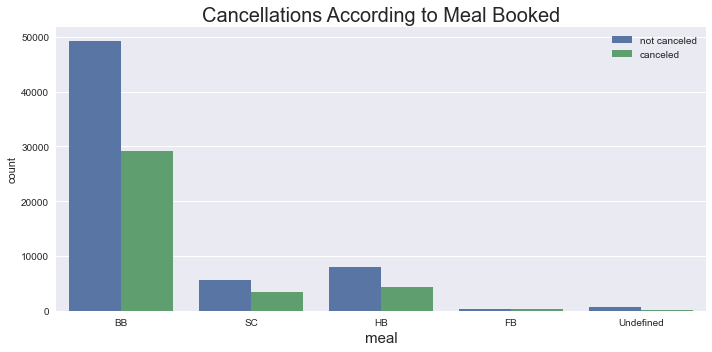

In [60]:
# plot meal according to cancellations
plt.figure(figsize=(10, 5))
sns.countplot(x=df2["meal"], hue=df2["is_canceled"])
plt.title("Cancellations According to Meal Booked", size=20)
plt.xlabel("meal", size=15)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

> ### Observations:
>> * The BB (Bed & Breakfast) meal is most common. It is also most frequently canceled.

> ### Cancellations According to Market Segment, Distribution Channel, Customer Type and Room Type

In [61]:
df2["market_segment"].value_counts()

Online TA        48113
Offline TA/TO    20585
Groups           16769
Direct           10689
Corporate         4485
Complementary      639
Aviation           199
Undefined            2
Name: market_segment, dtype: int64

In [62]:
# calculate cancellation percentage according to market segment
market_segment_percent = []

market_segment_1 = canceled["market_segment"].value_counts()
market_segment_total = df2["market_segment"].value_counts()

for i in market_segment_total.index:
    market_segment_percent.append(str(i + ": ") +
                                  str(round((market_segment_1[i] / market_segment_total[i]) * 100, 2)))
market_segment_percent

['Online TA: 36.57',
 'Offline TA/TO: 34.19',
 'Groups: 60.65',
 'Direct: 15.51',
 'Corporate: 18.71',
 'Complementary: 13.15',
 'Aviation: 22.11',
 'Undefined: 100.0']

In [63]:
df2["distribution_channel"].value_counts()

TA/TO        83251
Direct       12412
Corporate     5652
GDS            161
Undefined        5
Name: distribution_channel, dtype: int64

In [64]:
# calculate cancellation percentage according to distribution channel
distribution_channel_percent = []

distribution_channel_1 = canceled["distribution_channel"].value_counts()
distribution_channel_total = df2["distribution_channel"].value_counts()

for i in distribution_channel_total.index:
    distribution_channel_percent.append(str(i + ": ") +
                                        str(round((distribution_channel_1[i] / distribution_channel_total[i]) * 100,
                                                  2)))
distribution_channel_percent

['TA/TO: 40.81',
 'Direct: 17.6',
 'Corporate: 21.89',
 'GDS: 19.88',
 'Undefined: 80.0']

In [65]:
df2["customer_type"].value_counts()

Transient          76111
Transient-Party    21426
Contract            3448
Group                496
Name: customer_type, dtype: int64

In [66]:
# calculate cancellation percentage according to customer type
customer_type_percent = []

customer_type_1 = canceled["customer_type"].value_counts()
customer_type_total = df2["customer_type"].value_counts()

for i in customer_type_total.index:
    customer_type_percent.append(str(i + ": ") +
                                 str(round((customer_type_1[i] / customer_type_total[i]) * 100, 2)))
customer_type_percent

['Transient: 40.6', 'Transient-Party: 25.28', 'Contract: 31.0', 'Group: 9.48']

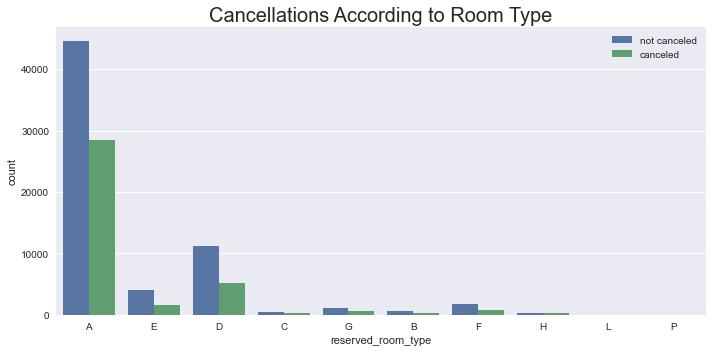

In [67]:
# plot of cancellations according to room type
plt.figure(figsize=(10, 5))
sns.countplot(x=df2["reserved_room_type"], hue=df2["is_canceled"])
plt.title("Cancellations According to Room Type", size=20)
plt.legend(["not canceled", "canceled"], loc=1)
plt.tight_layout()
plt.show()

> ### Observations:
>> * Market segment cancellation rates are highest amongst travel agencies and tour operators.
>> * Distribution channel cancellation rates are highest amongst groups, travel agencies and tour operators.
>> * Customer type cancellation rates are highest amongst transient
>> (meaning the booking is not part of a group or contract and is not associated to another transient booking).
>> * The room type "A" is canceled most frequently.

> ### Cancellations According to Deposit Type

In [68]:
df2["deposit_type"].value_counts()

No Deposit    89037
Non Refund    12304
Refundable      140
Name: deposit_type, dtype: int64

In [69]:
# calculate deposit type instances percentage in data
deposit_percent = round(df2["deposit_type"].value_counts() / len(df["deposit_type"]) * 100, 4)
deposit_percent

No Deposit    74.5766
Non Refund    10.3057
Refundable     0.1173
Name: deposit_type, dtype: float64

In [70]:
# use groupby to divide according to deposit type
deposit = df2.groupby(by="deposit_type")
non_refund = deposit.get_group("Non Refund")
refundable = deposit.get_group("Refundable")
no_deposit = deposit.get_group("No Deposit")

In [71]:
# calculate number of cancellations according to deposit type
no_deposit_0 = (no_deposit["is_canceled"] == 0).sum()
no_deposit_1 = (no_deposit["is_canceled"] == 1).sum()
non_refund_0 = (non_refund["is_canceled"] == 0).sum()
non_refund_1 = (non_refund["is_canceled"] == 1).sum()
refundable_0 = (refundable["is_canceled"] == 0).sum()
refundable_1 = (refundable["is_canceled"] == 1).sum()
all_canceled = no_deposit_1 + non_refund_1 + refundable_1
all_not_canceled = no_deposit_0 + non_refund_0 + refundable_0

In [72]:
# check that all values were calculated
all_canceled + all_not_canceled == df2["deposit_type"].size

True

In [73]:
# create a DataFrame with the number of instances for each deposit type
df_deposit_type = pd.DataFrame(index=["Not Canceled", "Canceled"])
df_deposit_type["no_deposit"] = [no_deposit_0, no_deposit_1]
df_deposit_type["non_refund"] = [non_refund_0, non_refund_1]
df_deposit_type["refundable"] = [refundable_0, refundable_1]
df_deposit_type

,no_deposit,non_refund,refundable
Not Canceled,63860,81,108
Canceled,25177,12223,32


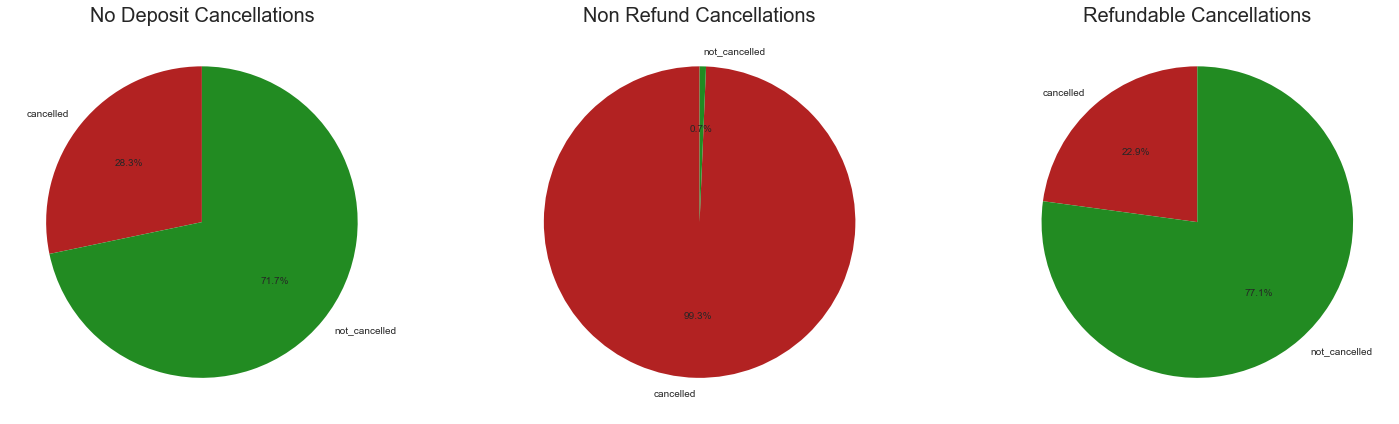

In [74]:
# pie plot of cancellations according to deposit type
cancel_labels = ["cancelled", "not_cancelled"]
fig, dx = plt.subplots(1, 3, figsize=(21, 6))
dx[0].pie(np.array([no_deposit_1, no_deposit_0]), labels=cancel_labels, autopct='%1.1f%%', startangle=90,
          colors=['firebrick', 'forestgreen'])
dx[0].set_title("No Deposit Cancellations", size=20)
dx[1].pie(np.array([non_refund_1, non_refund_0]), labels=cancel_labels, autopct='%1.1f%%', startangle=90,
          colors=['firebrick', 'forestgreen'])
dx[1].set_title("Non Refund Cancellations", size=20)
dx[2].pie(np.array([refundable_1, refundable_0]), labels=cancel_labels, autopct='%1.1f%%', startangle=90,
          colors=['firebrick', 'forestgreen'])
dx[2].set_title("Refundable Cancellations", size=20)
plt.tight_layout()
plt.show()

> #### Observations:
>> * The non refund values and graph look a bit off. It almost seems that the values
>> for canceled and not canceled were accidentally switched!
>> In light of this, it might be better to evaluate the model both with and without this
>> feature.

> ### Cancellations According to Country of Origin

In [75]:
df2["country"].unique().size

175

In [76]:
canceled["country"].value_counts()

PRT    23227
GBR     2069
ESP     1832
FRA     1658
ITA     1148
       ...  
UMI        1
GNB        1
NIC        1
ALB        1
KEN        1
Name: country, Length: 125, dtype: int64

In [77]:
# calculate countries by number of instances that appear in data
country_1 = (df2["country"].value_counts() <= 1).sum()
country_10 = (df2["country"].value_counts() <= 10).sum()
country_50 = (df2["country"].value_counts() <= 50).sum()
country_100 = (df2["country"].value_counts() <= 100).sum()
country_1000 = (df2["country"].value_counts() <= 1000).sum()

print("Number of countries with one or less instances:", country_1,
      "\nNumber of countries with 10 or less instances:", country_10,
      "\nNumber of countries with 50 or less instances:", country_50,
      "\nNumber of countries with 100 or less instances:", country_100,
      "\nNumber of countries with 1000 or less instances:", country_1000)

Number of countries with one or less instances: 33 
Number of countries with 10 or less instances: 88 
Number of countries with 50 or less instances: 123 
Number of countries with 100 or less instances: 139 
Number of countries with 1000 or less instances: 161


> ### Observations:
>> * There are 175 unique countries. This indicates that the data is representative
>> worldwide, contrary to a specific region.
>> * More than half of the instances have 50 or fewer observations in the DataFrame.
>> * A model would likely generalize better if we avoid using this column.

<a id="three"></a>

# 3. Data Cleaning

In [78]:
# clean copy of the training set
df3 = train_set.copy()

In [79]:
# custom transformer removes instances with zero guests

class RemoveZeroGuests(TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        XData = X.loc[((X["adults"]) + (X["children"]) + (X["babies"])) > 0]
        return XData

In [80]:
df3.shape

(101481, 32)

In [81]:
# use transformer to remove instances with zero guests stayed
df3 = RemoveZeroGuests().fit_transform(df3)

In [82]:
df3.shape

(101327, 32)

In [83]:
# separate features from target values

# drop- creates a copy without changing the training set
X_train = df3.drop("is_canceled", axis=1)

# create a deep copy of the target values
y_train = df3["is_canceled"].copy()

> ### Removing the Following Columns:
>> #### Numerical Attributes:
>> * arrival_date_year: This category references towards certain years. This could be
>> problematic for instances during years that do not appear in the training data, or
>> perhaps have bias towards certain years specifically due to the unequal amounts of
>> observations in the training data.
>> * arrival_date_day_of_month: The column arrival date week of month generalizes this.
>> * booking_changes: Could change over time, potentially causing data leakage.
>> * days_in_waiting_list: Could constantly change over time. Additionally, there are many
>> instances. This could prevent the model from generalizing.
>> * agent & company: Represented by an ID. These columns are uninformative since they
>> contain a substantial amount of various numerical values without having an actual
>> numerical meaning. Since other columns (such as market segment) indicate the type of
>> reservation, these columns won't be needed.
>>
>> #### Categorical Attributes:
>> * country: There are many categories, most with few instances. In order to make a model
>> that generalizes, it is better to dismiss this category.
>> * assigned_room_type: Similar to reserved_room_type and seems like the reserved room is
>> a more suitable choice.
>> * reservation_status: Major data leakage! The categories are Check-Out, Canceled and No-Show.
>> This is exactly what we are trying to predict.
>> * reservation_status_date: This is the date when the reservation status was last changed,
>> and therefore is irrelevant.

In [84]:
num_features = ["lead_time", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies",
                "is_repeated_guest", "previous_cancellations", "previous_bookings_not_canceled", "adr",
                "required_car_parking_spaces", "total_of_special_requests"]

cat_features = ["hotel", "arrival_date_month", "arrival_date_week_number", "meal", "market_segment",
                "distribution_channel", "reserved_room_type", "deposit_type", "customer_type"]

In [85]:
# Undefined/SC both represent no meal package and can be combined

class ReplaceMeal(TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        XData = X.copy()
        XData["meal"].replace("Undefined", "SC", inplace=True)
        return XData

In [86]:
# SimpleImputer constant default fills values with zero
# MinMaxScaler normalizes data (rescales between 0-1)
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant")),
    ("min_max", MinMaxScaler())
])

In [87]:
# SimpleImputer fills missing values with 'Unknown'
# OneHotEncoder converts categories to a numeric dummy array
# (one binary attribute per category)
cat_pipeline = Pipeline([
    ("meal", ReplaceMeal()),
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

In [88]:
# column transformer:
# features generated by each transformer will be concatenated to form a single feature space
# columns of the original feature matrix that are not specified are dropped
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_features),
    ("categorical", cat_pipeline, cat_features)
])

In [89]:
# transform training data using pipeline
X_train_prepared = full_pipeline.fit_transform(X_train)

<a id="four"></a>

# 4. Training and Evaluating Models

> Accuracy is less relevant for an imbalanced classification problem.
> Evaluating by a metric that represents the data better is important.
>
> Chosen evaluation metric:
>
> The F1 Score is calculated by using precision (the accuracy of the positive predictions) and
> recall (the ratio of positive instances correctly classified) accuracy.
> This metric gives a higher value towards false positives rather than false negatives.

In [90]:
# function prints scores
def display_evaluation(actual, pred, print_report=False):
    print("F1 Score:", round(metrics.f1_score(actual, pred), 5), "\n")
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    if print_report:
        print("Classification Report:\n", metrics.classification_report(actual, pred))

#### Model 1: KNN

In [91]:
# instantiate classifier
# default k=5
knn = KNeighborsClassifier()
# knn.fit(X_train_prepared, y_train) # fit the training set
# joblib.dump(knn, "bookings/models/knn1.pkl")
knn = joblib.load(r"bookings/models/knn1.pkl")

# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", knn.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0 0 0 0 0 1 0 1 0 0]
Labels: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


In [92]:
# knn_pred = knn.predict(X_train_prepared) # predict using the training data
# joblib.dump(knn_pred, "bookings/pred/knn1_pred.pkl")
knn_pred = joblib.load(r"bookings/pred/knn1_pred.pkl")
display_evaluation(y_train, knn_pred)  # use function to show results

F1 Score: 0.80691 

Confusion Matrix:
 [[58977  4943]
 [ 8765 28642]] 



#### Model 2: KNN

In [93]:
# instantiate KNN model using distance instead of uniform
# distance means closer instances have a larger weight
# uniform weighs all instances equally
# default k=5
knn = KNeighborsClassifier(weights="distance")
# knn.fit(X_train_prepared, y_train) # fit the training set
# joblib.dump(knn, "bookings/models/knn2.pkl")
knn = joblib.load(r"bookings/models/knn2.pkl")

# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", knn.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0 0 0 0 0 0 1 1 1 0]
Labels: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


In [94]:
# knn2_pred = knn.predict(X_train_prepared) # predict using the training data
# joblib.dump(knn2_pred, "bookings/pred/knn2_pred.pkl")
knn2_pred = joblib.load(r"bookings/pred/knn2_pred.pkl")
display_evaluation(y_train, knn2_pred)  # use function to show results

F1 Score: 0.98576 

Confusion Matrix:
 [[63548   372]
 [  689 36718]] 



> So far, the performance of the KNN model using distance weights instead of uniform
> drastically improved the results.

#### Model 3: Random Forest Classifier

> ### What is the Random Forest Classification Model?

Forests are based on multiple decision trees, so it is vital to first understand how decision
trees work.

A decision tree is a non-linear model built by constructing many linear boundaries.
The tree works as a sequence of yes or no, true or false questions that progress down
the tree until reaching a predicted class. The data is split into nodes based on
feature values. This model is good for occasions when there is no single linear line that
can divide the data. Gini Impurity of a node represents the probability that a randomly chosen
sample would be incorrectly classified, so the goal is to reduce this as much as possible.

Using a single decision tree could cause overfitting of the training data. For example,
a decision tree could create a leaf node (the predicted class) for each instance.
Using a forest could help generalize better to new data. The random forest model
samples random points and subsets of features when training. Then, the predictions are made
by averaging the predictions made by each decision tree.

In [95]:
# max features default is sqrt (number of features selected per split)
# bootstrap default is true (resampling data true)
# n estimators default is 100 (number of decision tree classifiers)
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf_clf.fit(X_train_prepared, y_train) # fit the training set
# joblib.dump(rf_clf, "bookings/models/rf_clf1.pkl")
rf_clf = joblib.load(r"bookings/models/rf_clf1.pkl")

# test on a few instances from training data
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", rf_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0 0 0 0 0 0 1 1 1 0]
Labels: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


In [96]:
# rf_pred = rf_clf.predict(X_train_prepared) # predict using the training data
# joblib.dump(rf_pred, "bookings/pred/rf_clf1_pred.pkl")
rf_pred = joblib.load(r"bookings/pred/rf_clf1_pred.pkl")
display_evaluation(y_train, rf_pred)  # use function to show results

F1 Score: 0.98663 

Confusion Matrix:
 [[63607   313]
 [  682 36725]] 



> The Random Forest Classification model performed slightly better than the second
> KNN model. The next step is to find the hyperparameters
> that provide the best results.
>
> Since the dataset is rather large, and it would take a long time
> to run all estimators, using randomized search cv is the ideal
> option. The size of the dataset is also the reason I have neglected
> randomized search for the KNN model.
>
> The randomized search runs an amount of iterations specified
> and tries random combinations of the attributes listed.

> Before Tuning:

In [97]:
# rf_pred_before = cross_val_predict(rf_clf, X_train_prepared, y_train, cv=5, verbose=2)
# joblib.dump(rf_pred_before, "bookings/pred/rf_pred_before.pkl")
rf_pred_before = joblib.load(r"bookings/pred/rf_pred_before.pkl")
display_evaluation(y_train, rf_pred)
metrics.f1_score(y_train, rf_pred_before)

F1 Score: 0.98663 

Confusion Matrix:
 [[63607   313]
 [  682 36725]] 



0.7943834640057021

#### Random Search Cross Validation 1

In [98]:
# parameters for random search
param_dist_rf = [{"n_estimators": [10, 50, 100, 500], "max_features": ["sqrt", 8, 16], "bootstrap": [True, False]}]
# instantiate randomized search
rf_cv = RandomizedSearchCV(rf_clf, param_dist_rf, n_iter=10, random_state=42, cv=5, scoring="f1")
# rf_cv.fit(X_train_prepared, y_train) # fit the training set
# joblib.dump(rf_cv, "bookings/scores/rf_cv1.pkl")
rf_cv = joblib.load(r"bookings/scores/rf_cv1.pkl")

In [99]:
# show the best score
rf_cv.best_score_

0.7991628082032618

In [100]:
# show the best estimator parameters
rf_clf2 = rf_cv.best_estimator_
rf_clf2

RandomForestClassifier(max_features=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [101]:
# show results for each iteration
cvres = rf_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.78073 {'n_estimators': 10, 'max_features': 16, 'bootstrap': True}
0.77888 {'n_estimators': 10, 'max_features': 8, 'bootstrap': False}
0.77867 {'n_estimators': 10, 'max_features': 'sqrt', 'bootstrap': True}
0.7892 {'n_estimators': 100, 'max_features': 8, 'bootstrap': False}
0.79916 {'n_estimators': 500, 'max_features': 16, 'bootstrap': True}
0.79605 {'n_estimators': 50, 'max_features': 16, 'bootstrap': True}
0.78996 {'n_estimators': 50, 'max_features': 'sqrt', 'bootstrap': False}
0.79279 {'n_estimators': 50, 'max_features': 'sqrt', 'bootstrap': True}
0.79337 {'n_estimators': 50, 'max_features': 16, 'bootstrap': False}
0.79074 {'n_estimators': 50, 'max_features': 8, 'bootstrap': True}


#### Model 4: Random Forest Classifier

In [102]:
# rf_clf2_pred = cross_val_predict(rf_clf2, X_train_prepared, y_train, cv=5, verbose=2)
# joblib.dump(rf_clf2_pred, "bookings/pred/rf_clf2_pred.pkl")
rf_clf2_pred = joblib.load(r"bookings/pred/rf_clf2_pred.pkl")
display_evaluation(y_train, rf_clf2_pred)  # display evaluation scores

F1 Score: 0.79916 

Confusion Matrix:
 [[59028  4892]
 [ 9257 28150]] 



#### Feature Importance

In [103]:
# pair the feature names with the results from randomized search
feature_importance = rf_cv.best_estimator_.feature_importances_
features = num_features + cat_features
sorted(zip(feature_importance, features), reverse=True)

[(0.16118362429277072, 'lead_time'),
 (0.11086779060263112, 'adr'),
 (0.0599602778426879, 'total_of_special_requests'),
 (0.05056320624761356, 'stays_in_week_nights'),
 (0.03957611116006944, 'previous_cancellations'),
 (0.03281066695110617, 'stays_in_weekend_nights'),
 (0.022474263702596767, 'required_car_parking_spaces'),
 (0.017276395063004255, 'adults'),
 (0.00740954216206894, 'children'),
 (0.006787490796244419, 'hotel'),
 (0.006247423364587789, 'arrival_date_month'),
 (0.0050279961594726945, 'deposit_type'),
 (0.004610996180061733, 'meal'),
 (0.004503642204425172, 'customer_type'),
 (0.004460744145312597, 'arrival_date_week_number'),
 (0.003953187308655435, 'previous_bookings_not_canceled'),
 (0.0035960665798245293, 'distribution_channel'),
 (0.0031149369629089115, 'market_segment'),
 (0.002602523363804602, 'reserved_room_type'),
 (0.002209948979420808, 'is_repeated_guest'),
 (0.0011738575904849042, 'babies')]

> Deposit type is pretty high on the list which raises speculation. As seen earlier,
> the cancellation rate was nearly 100% in the category Non Refund.
> Lets train a model without this feature.
>
> Additionally, lets train a model without the parameters that have less
> than 0.005 feature importance. If the training error is nearly the
> same when using fewer features, it might be more efficient to
> train a model without them.

In [104]:
# features left

num_features_2 = ["lead_time", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children",
                  "previous_cancellations", "adr", "required_car_parking_spaces", "total_of_special_requests"]

cat_features_2 = ["hotel", "arrival_date_month"]

# category pipeline without meal transformer
cat_pipeline_2 = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

# pipeline with new features
full_pipeline_2 = ColumnTransformer([
    ("numerical", num_pipeline, num_features_2),
    ("categorical", cat_pipeline_2, cat_features_2)
])

In [105]:
# transform data with new pipeline
X_train_prepared_2 = full_pipeline_2.fit_transform(X_train)

#### Model 5: Random Forest Classifier

In [106]:
# instantiate model
rf_clf3 = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf_clf3.fit(X_train_prepared_2, y_train) # fit the training set
# joblib.dump(rf_clf3, "bookings/models/rf_clf3.pkl")
rf_clf3 = joblib.load(r"bookings/models/rf_clf3.pkl")
# rf_clf3_pred = rf_clf3.predict(X_train_prepared_2) # predictions on training data
# joblib.dump(rf_clf3_pred, "bookings/pred/rf_clf3_pred.pkl")
rf_clf3_pred = joblib.load(r"bookings/pred/rf_clf3_pred.pkl")
display_evaluation(y_train, rf_clf3_pred)  # display evaluation scores

F1 Score: 0.98247 

Confusion Matrix:
 [[63512   408]
 [  895 36512]] 



#### Random Search Cross Validation 2

In [107]:
# parameters for random search
param_dist = [{"n_estimators": [10, 50, 100, 500], "max_features": [4, 8, 16], "bootstrap": [True, False]}]
rf_cv2 = RandomizedSearchCV(rf_clf3, param_dist, cv=5, n_iter=10, scoring="f1",
                            random_state=42)  # instantiate randomized search
# rf_cv2.fit(X_train_prepared_2, y_train) # fit the training set
# joblib.dump(rf_cv2, "bookings/scores/rf_cv2.pkl")
rf_cv2 = joblib.load(r"bookings/scores/rf_cv2.pkl")

In [108]:
# show the best score
rf_cv2.best_score_

0.7598261972629967

In [109]:
# show the best estimator parameters
rf_clf4 = rf_cv2.best_estimator_
rf_clf4

RandomForestClassifier(max_features=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [110]:
# show results for each iteration
cvres = rf_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.74426 {'n_estimators': 10, 'max_features': 16, 'bootstrap': True}
0.74764 {'n_estimators': 10, 'max_features': 8, 'bootstrap': False}
0.74215 {'n_estimators': 10, 'max_features': 4, 'bootstrap': True}
0.75542 {'n_estimators': 100, 'max_features': 8, 'bootstrap': False}
0.75983 {'n_estimators': 500, 'max_features': 16, 'bootstrap': True}
0.75608 {'n_estimators': 50, 'max_features': 16, 'bootstrap': True}
0.75021 {'n_estimators': 50, 'max_features': 4, 'bootstrap': False}
0.75506 {'n_estimators': 50, 'max_features': 4, 'bootstrap': True}
0.7492 {'n_estimators': 50, 'max_features': 16, 'bootstrap': False}
0.75857 {'n_estimators': 50, 'max_features': 8, 'bootstrap': True}


In [111]:
# predict using training data
# rf_clf4_pred = cross_val_predict(rf_clf4, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(rf_clf4_pred, "bookings/pred/rf_clf4_pred.pkl")
rf_clf4_pred = joblib.load(r"bookings/pred/rf_clf4_pred.pkl")
display_evaluation(y_train, rf_clf4_pred, True)  # display evaluation scores

F1 Score: 0.75983 

Confusion Matrix:
 [[57807  6113]
 [10743 26664]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87     63920
           1       0.81      0.71      0.76     37407

    accuracy                           0.83    101327
   macro avg       0.83      0.81      0.82    101327
weighted avg       0.83      0.83      0.83    101327



#### Dummy Classifier
> The dummy classifier serves as an indication and comparison for model performance.

In [112]:
# dummy classifier
# classifies every instance as not canceled
# BaseEstimator allows to set and get estimator parameters
class NeverCanceledClassifier(BaseEstimator):

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=int)

In [113]:
# instantiate dummy classifier
never_canceled = NeverCanceledClassifier()

In [114]:
# fit the training set
never_canceled.fit(X_train, y_train)

In [115]:
# predict using dummy classifier
never_canceled_pred = never_canceled.predict(X_train)

In [116]:
# evaluate scores for comparison
# can't assess using F1 score
# precision will divide by zero
print("Accuracy:", metrics.accuracy_score(y_train, never_canceled_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, never_canceled_pred))

Accuracy: 0.6308289004904912
Confusion Matrix:
 [[63920     0]
 [37407     0]]


> ### Overview:
>> ####  Removing nearly half of the features did not drastically change the score.
>> * The model prior to feature selection had an F1 score of 0.99.
>> * The model after feature selection has an F1 score of 0.98.
>> * The model performs better than the dummy classifier.

In [117]:
# use predictions to get precision recall curve values
rf_scores = rf_cv2.best_estimator_.predict_proba(X_train_prepared_2)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, rf_scores)

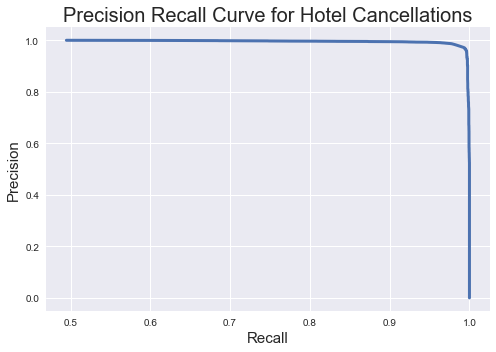

In [118]:
# plot precision recall curve
plt.figure(figsize=(7, 5))
plt.plot(precisions, recalls, linewidth=3)
plt.title("Precision Recall Curve for Hotel Cancellations", size=20)
plt.xlabel("Recall", size=15)
plt.ylabel("Precision", size=15)
plt.tight_layout()
plt.show()

<a id="five"></a>

# 5. Evaluating the Test Set

In [119]:
# separate test set predictors and labels
X_test = test_set.drop("is_canceled", axis=1)
y_test = test_set["is_canceled"].copy()

In [120]:
# transform test set
X_test_prep = full_pipeline_2.transform(X_test)

In [121]:
final_model = rf_cv2.best_estimator_
final_model

RandomForestClassifier(max_features=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [122]:
final_predictions = final_model.predict(X_test_prep)  # predict test set
display_evaluation(y_test, final_predictions, True)  # evaluate predictions

F1 Score: 0.77825 

Confusion Matrix:
 [[10124   993]
 [ 1833  4959]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     11117
           1       0.83      0.73      0.78      6792

    accuracy                           0.84     17909
   macro avg       0.84      0.82      0.83     17909
weighted avg       0.84      0.84      0.84     17909



In [123]:
# save a local copy of the final model
# joblib.dump(final_model, "bookings/models/final_model_A.pkl")

<a id='section_b'></a>

## Section B: Using Different ML Techniques to Improve Prediction Results

In this second part, I will attempt to improve the prediction score of my previous project by
using the knowledge and skills I have gained the past several months.

> Important Notes:
* Feature importance was explored in the previous section. 111 features were reduced to 23 (recall that
the number of columns is greater than the originally explored dataset. This is due to the fact that
OneHotEncoder converts categories to a numeric dummy array which adds columns).
I will be using the data transformed from the most recent feature selection.
* PCA is also trickier to apply here since I chose to use MinMaxScaler during the first part of
the project, which normalizes the data to the range [0, 1]. PCA requires a zero mean, which is
achieved when using StandardScaler.

In [124]:
# function for evaluating cross-validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 5))
    print("Standard Deviation:", round(scores.std(), 5))

In [125]:
final_model_A = joblib.load(r"bookings/models/final_model_A.pkl")
final_model_A

RandomForestClassifier(max_features=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [126]:
# cross-validation prediction of previous final model
display_evaluation(y_test, final_predictions, True)

F1 Score: 0.77825 

Confusion Matrix:
 [[10124   993]
 [ 1833  4959]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     11117
           1       0.83      0.73      0.78      6792

    accuracy                           0.84     17909
   macro avg       0.84      0.82      0.83     17909
weighted avg       0.84      0.84      0.84     17909



# 6. Model Improvements- First Attempt:
## Fine-Tune the Random Forest model.
> This is the final model used in the previous section.
> To kick-start this project, I will fine-tune the Random Forest model again.
> I have studied this Machine Learning algorithm in depth since then and believe
> I have better knowledge of the hyperparameters.

> Previous Model:

In [127]:
display_evaluation(y_train, rf_clf4_pred)

F1 Score: 0.75983 

Confusion Matrix:
 [[57807  6113]
 [10743 26664]] 



> Tuning the maximum number of features per tree:

In [128]:
param_grid = [{
    "max_features": ['sqrt', "log2", 0.1, 0.2, 0.5, 0.8, None]
    # max features that are evaluated before splitting a node
}]

In [129]:
rf_cv3 = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, scoring="f1", cv=5, verbose=2)
# rf_cv3.fit(X_train_prepared_2, y_train)
# joblib.dump(rf_cv3, "bookings/scores/rf_cv3.pkl")
rf_cv3 = joblib.load(r"bookings/scores/rf_cv3.pkl")

In [130]:
rf_cv3.best_score_

0.75937797040982

In [131]:
rf_clf5 = rf_cv3.best_estimator_
rf_clf5

RandomForestClassifier(max_features=0.5, n_jobs=-1, random_state=42)

In [132]:
# show results for each iteration
cvres = rf_cv3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.75689 {'max_features': 'sqrt'}
0.75689 {'max_features': 'log2'}
0.75223 {'max_features': 0.1}
0.75689 {'max_features': 0.2}
0.75938 {'max_features': 0.5}
0.75859 {'max_features': 0.8}
0.75727 {'max_features': None}


In [133]:
param_grid = [{
    "max_features": [0.3, 0.4, 0.5, 0.6, 0.7]
}]

In [134]:
rf_cv4 = GridSearchCV(rf_clf5, param_grid, scoring="f1", cv=5, verbose=2)
# rf_cv4.fit(X_train_prepared_2, y_train)
# joblib.dump(rf_cv4, "bookings/scores/rf_cv4.pkl")
rf_cv4 = joblib.load(r"bookings/scores/rf_cv4.pkl")

In [135]:
rf_cv4.best_score_

0.7612587216860941

In [136]:
rf_clf6 = rf_cv4.best_estimator_
rf_clf6

RandomForestClassifier(max_features=0.4, n_jobs=-1, random_state=42)

In [137]:
# show results for each iteration
cvres = rf_cv4.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.75787 {'max_features': 0.3}
0.76126 {'max_features': 0.4}
0.75938 {'max_features': 0.5}
0.75999 {'max_features': 0.6}
0.75905 {'max_features': 0.7}


> Tuning number of trees and criterion with Bagging and Pasting:
>> Note- The main difference between the criterion:
- Gini is faster to compute and tends to separate the most frequent class to its own branch.
- Entropy takes longer to compute and is likely to have more balanced trees.

In [138]:
param_grid = [{
    "n_estimators": [100, 200, 300],  # max features in an individual tree
    "bootstrap": [True, False],  # sampling with or without replacement
    # True (Scikit-learn default) = bagging, False = pasting
    "criterion": ["gini", "entropy"]  # function to measure quality of split
}]

In [139]:
rf_cv5 = GridSearchCV(rf_clf6, param_grid, scoring="f1", cv=5, verbose=2)
# rf_cv5.fit(X_train_prepared_2, y_train)
# joblib.dump(rf_cv5, "bookings/scores/rf_cv5.pkl")
rf_cv5 = joblib.load(r"bookings/scores/rf_cv5.pkl")

In [140]:
rf_cv5.best_score_

0.7617297093621068

In [141]:
rf_clf7 = rf_cv5.best_estimator_
rf_clf7

RandomForestClassifier(max_features=0.4, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [142]:
# show results for each iteration
cvres = rf_cv5.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.76126 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}
0.76165 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 200}
0.76173 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 300}
0.76008 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
0.76125 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 200}
0.7613 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300}
0.75616 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 100}
0.75627 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 200}
0.7566 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 300}
0.75578 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 100}
0.75581 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 200}
0.75688 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 300}


> #### Observations:
* There is a minor difference between the highest score with 300 estimators and 200 estimators.
* 200 estimators reduces computational complexity while maintaining nearly the same score.

> **Final Random Forest model:** 200 estimators, bagging method (sampling with replacement), gini criterion,
> and considers 0.4 features when splitting a node.
>> Note: The Random Forest model has a higher F1 score than the previous one!

In [143]:
rf_clf_final = RandomForestClassifier(n_estimators=200, criterion="entropy", max_features=0.4, random_state=42, n_jobs=-1)
# rf_clf_final.fit(X_train_prepared_2, y_train)
# joblib.dump(rf_clf_final, "bookings/models/rf_clf_final.pkl")
rf_clf_final = joblib.load(r"bookings/models/rf_clf_final.pkl")

# rf_clf_final_pred = cross_val_predict(rf_clf_final, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(rf_clf_final_pred, "bookings/pred/rf_clf_final_pred.pkl")
rf_clf_final_pred = joblib.load(r"bookings/pred/rf_clf_final_pred.pkl")
display_evaluation(y_train, rf_clf_final_pred, True)

F1 Score: 0.76126 

Confusion Matrix:
 [[58075  5845]
 [10827 26580]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87     63920
           1       0.82      0.71      0.76     37407

    accuracy                           0.84    101327
   macro avg       0.83      0.81      0.82    101327
weighted avg       0.83      0.84      0.83    101327



# 7. Model Improvements- Second Attempt:
## Fine-Tune the KNN model.
> When training models in section A I trained two KNN classifiers, each using different weights.
> The model that used distance weights deemed promising results.
> Now, I will use Grid Search to find the optimal parameters using distance weights.

> Baseline Model:

In [144]:
knn_clf = KNeighborsClassifier(weights="distance")
# knn_clf_pred = cross_val_predict(knn_clf, X_train_prepared_2, y_train, cv=5, verbose=2, n_jobs=-1)
# joblib.dump(knn_clf_pred, "bookings/pred/knn_clf_pred.pkl")
knn_clf_pred = joblib.load(r"bookings/pred/knn_clf_pred.pkl")
display_evaluation(y_train, knn_clf_pred)

F1 Score: 0.72542 

Confusion Matrix:
 [[55657  8263]
 [11414 25993]] 



> Tuning the number of neighbors and penalty:
>> Note: There is an even number of classes. It is better to choose an odd number of neighbors to
>> prevent ties.

In [145]:
param_grid = [{
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    "weights": ["distance"],
    "p": [1, 2]
}]

In [146]:
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="f1", cv=5, n_jobs=-1, verbose=2)
# knn_cv.fit(X_train_prepared_2, y_train)
# joblib.dump(knn_cv, "bookings/scores/knn_cv1.pkl")
knn_cv = joblib.load(r"bookings/scores/knn_cv1.pkl")

In [147]:
knn_cv.best_score_

0.7345900961987614

In [148]:
knn2 = knn_cv.best_estimator_
knn2

KNeighborsClassifier(n_neighbors=23, p=1, weights='distance')

In [149]:
# show results for each iteration
cvres = knn_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.72427 {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.72183 {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.72713 {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.72542 {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.72925 {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.72876 {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
0.73128 {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
0.72922 {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
0.7319 {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
0.73103 {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
0.73355 {'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.73164 {'n_neighbors': 13, 'p': 2, 'weights': 'distance'}
0.73325 {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
0.73181 {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
0.73401 {'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
0.73158 {'n_neighbors': 17, 'p': 2, 'weights': 'distance'}
0.73444 {'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
0.732 

> **Final KNN model:** Distance weights, l1 norm and 17 neighbors.

In [150]:
knn_final = KNeighborsClassifier(n_neighbors=17, weights="distance", p=1, n_jobs=-1)
# knn_final.fit(X_train_prepared_2, y_train)
# joblib.dump(knn_final, "bookings/models/knn_final.pkl")
knn_final = joblib.load(r"bookings/models/knn_final.pkl")
# knn_final_pred = cross_val_predict(knn_final, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(knn_final_pred, "bookings/pred/knn_final_pred.pkl")
knn_final_pred = joblib.load(r"bookings/pred/knn_final_pred.pkl")
display_evaluation(y_train, knn_final_pred, True)

F1 Score: 0.73401 

Confusion Matrix:
 [[57675  6245]
 [12098 25309]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86     63920
           1       0.80      0.68      0.73     37407

    accuracy                           0.82    101327
   macro avg       0.81      0.79      0.80    101327
weighted avg       0.82      0.82      0.82    101327



# 8. Model Improvements- Third Attempt:
## Train and Tune a Logistic Regression model.
> This is a linear model that generally works well with large datasets. Additionally, the tuned model
> can be used later on for various ensemble methods.
>> Note: When dealing with imbalanced labels, calculating the class weights can improve this model.

> Baseline Model:

In [151]:
# calculate class weights
n_samples = len(y_train)  # total number of instances
w0 = round(n_samples / y_train.value_counts()[0], 5)  # divide n_samples to determine class 0 ratio
w1 = round(n_samples / y_train.value_counts()[1], 5)  # divide n_samples to determine class 1 ratio
weights = {0: w0, 1: w1}  # dictionary to pass to model hyperparameter

In [152]:
log_reg = LogisticRegression(class_weight=weights, random_state=42, n_jobs=-1)
# log_reg_pred = cross_val_predict(log_reg, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(log_reg_pred, "bookings/pred/log_reg_pred.pkl")
log_reg_pred = joblib.load(r"bookings/pred/log_reg_pred.pkl")
display_evaluation(y_train, log_reg_pred)

F1 Score: 0.63621 

Confusion Matrix:
 [[44311 19609]
 [10809 26598]] 



> Tuning solver, penalty and regularization strength:

In [153]:
param_grid = [{
    "solver": ["lbfgs", "liblinear", "sag", "saga"]
}]

In [154]:
log_reg_cv = GridSearchCV(LogisticRegression(class_weight=weights, random_state=42), param_grid, cv=5, scoring='f1', verbose=2)
# log_reg_cv.fit(X_train_prepared_2, y_train)
# joblib.dump(log_reg_cv, "bookings/scores/log_reg_cv.pkl")
log_reg_cv = joblib.load(r"bookings/scores/log_reg_cv.pkl")

In [155]:
log_reg_cv.best_score_

0.6364512229816668

In [156]:
log_reg2 = log_reg_cv.best_estimator_
log_reg2

LogisticRegression(class_weight={0: 1.58522, 1: 2.70877}, random_state=42,
                   solver='liblinear')

In [157]:
# show results for each iteration
cvres = log_reg_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.63599 {'solver': 'lbfgs'}
0.63645 {'solver': 'liblinear'}
0.6364 {'solver': 'sag'}
0.6364 {'solver': 'saga'}


In [158]:
param_grid = [{
    "penalty": ["l1", "l2"],  # liblinear supports l1 and l2 norms
    "C": [0.001, 0.05, 0.01, 0.1, 0.5, 1.]  # C controls regularization
    # light penalty if close to 1.0, strong penalty if close to 0.0
}]

In [159]:
log_reg_cv2 = GridSearchCV(log_reg2, param_grid, cv=5, scoring='f1', verbose=2)
# log_reg_cv2.fit(X_train_prepared_2, y_train)
# joblib.dump(log_reg_cv2, "bookings/scores/log_reg_cv2.pkl")
log_reg_cv2 = joblib.load(r"bookings/scores/log_reg_cv2.pkl")

In [160]:
log_reg_cv2.best_score_

0.637904124458194

In [161]:
log_reg3 = log_reg_cv2.best_estimator_
log_reg3

LogisticRegression(class_weight={0: 1.58522, 1: 2.70877}, penalty='l1',
                   random_state=42, solver='liblinear')

In [162]:
# show results for each iteration
cvres = log_reg_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.59844 {'C': 0.001, 'penalty': 'l1'}
0.58263 {'C': 0.001, 'penalty': 'l2'}
0.63758 {'C': 0.05, 'penalty': 'l1'}
0.6218 {'C': 0.05, 'penalty': 'l2'}
0.62207 {'C': 0.01, 'penalty': 'l1'}
0.61025 {'C': 0.01, 'penalty': 'l2'}
0.63773 {'C': 0.1, 'penalty': 'l1'}
0.62696 {'C': 0.1, 'penalty': 'l2'}
0.63777 {'C': 0.5, 'penalty': 'l1'}
0.63451 {'C': 0.5, 'penalty': 'l2'}
0.6379 {'C': 1.0, 'penalty': 'l1'}
0.63645 {'C': 1.0, 'penalty': 'l2'}


> **Final Logistic Regression model:** Liblinear solver, l1 norm, and 1.0 regularization strength.

In [163]:
log_reg_final = log_reg3
# log_reg_final_pred = cross_val_predict(log_reg_final, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(log_reg_final_pred, "bookings/pred/log_reg_final_pred.pkl")
log_reg_final_pred = joblib.load(r"bookings/pred/log_reg_final_pred.pkl")
display_evaluation(y_train, log_reg_final_pred, True)

F1 Score: 0.6379 

Confusion Matrix:
 [[44881 19039]
 [10972 26435]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75     63920
           1       0.58      0.71      0.64     37407

    accuracy                           0.70    101327
   macro avg       0.69      0.70      0.69    101327
weighted avg       0.72      0.70      0.71    101327



# 9. Model Improvements- Fourth Attempt:
## Train and Tune a Gradient Boosting model.
> Note: Since this is an imbalanced classification task, the weights need to be adjusted.
XGBoost contains a hyperparameter "scale_pos_weight" that is set by default to 1.0.
This parameter weighs the positive instances relative to the negative when boosting decision trees.
In other words, the parameter is used to scale the gradient for the positive class.

> Baseline Model:

In [164]:
estimate_weight = round(y_train.value_counts()[0] / y_train.value_counts()[1], 3)  # estimate scale_weight_pos value
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='aucpr', objective='binary:logistic', use_label_encoder=False,
                        scale_pos_weight=estimate_weight)
xgb_clf.fit(X_train_prepared_2, y_train)
xgb_pred = xgb_clf.predict(X_train_prepared_2)
display_evaluation(y_train, xgb_pred)

F1 Score: 0.75539 

Confusion Matrix:
 [[53456 10464]
 [ 8353 29054]] 



In [165]:
xgb_clf.best_iteration

99

> #### Observations:
* The best iteration was 99, meaning all 100 trees were trained. We can try increasing the number of
estimators in order to find the optimal value.

> Tuning the number of estimators:

In [166]:
params = {
    "scale_pos_weight": estimate_weight,
    "objective": "binary:logistic",
    "eval_metric": "aucpr"  # measures the area under the PR curve
}

# dmatrix is a data structure used by the XGBoost library that optimizes performance
# it is needed when using the XGBoost library cross-validation
dmat_train = DMatrix(X_train_prepared_2, y_train)

In [167]:
# xgb_scores_cv1 = cv(params, dmat_train, num_boost_round=500, nfold=5, early_stopping_rounds=5, seed=42, metrics="aucpr",
#                       verbose_eval=True)
# joblib.dump(xgb_scores_cv1, "bookings/scores/xgb_scores_cv1.pkl")
xgb_scores_cv1 = joblib.load(r"bookings/scores/xgb_scores_cv1.pkl")

In [168]:
curr_auc_max = xgb_scores_cv1["test-aucpr-mean"].argmax()
xgb_scores_cv1.loc[curr_auc_max]

train-aucpr-mean    0.940656
train-aucpr-std     0.001353
test-aucpr-mean     0.856250
test-aucpr-std      0.001679
Name: 464, dtype: float64

In [169]:
curr_std_min = xgb_scores_cv1["test-aucpr-std"].argmin()
xgb_scores_cv1.loc[curr_std_min]

train-aucpr-mean    0.932581
train-aucpr-std     0.001259
test-aucpr-mean     0.854423
test-aucpr-std      0.001525
Name: 390, dtype: float64

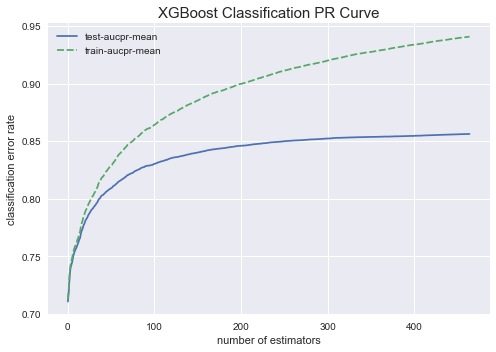

In [170]:
# plot classification errors from cross-validation
plt.figure(figsize=(7, 5))
sns.lineplot(data=[xgb_scores_cv1["test-aucpr-mean"], xgb_scores_cv1["train-aucpr-mean"]])
plt.xlabel("number of estimators")
plt.ylabel("classification error rate")
plt.title("XGBoost Classification PR Curve", size=15)
plt.tight_layout()
plt.show()

> #### Observations:
* The iteration with the lowest standard deviation has nearly the same AUC PR curve score as the one with
the highest mean. The difference is that the round with the highest mean uses 465 estimators and the
one with the lowest standard deviation uses 391. Furthermore, the graph growth is slow in between those
values. Therefore, I will use 391 estimators.

> Tuning weights for class imbalance:

In [171]:
param_grid = [{
    "scale_pos_weight": [1, estimate_weight, 2, 3, 10]
}]

In [172]:
xgb_scores_cv2 = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1, eval_metric='aucpr', objective='binary:logistic',
                                            use_label_encoder=False, scale_pos_weight=estimate_weight, n_estimators=391), param_grid,
                                            cv=5, scoring='f1', verbose=2)
# xgb_scores_cv2.fit(X_train_prepared_2, y_train)
# joblib.dump(xgb_scores_cv2, "bookings/scores/xgb_scores_cv2.pkl")
xgb_scores_cv2 = joblib.load(r"bookings/scores/xgb_scores_cv2.pkl")

In [173]:
xgb_scores_cv2.best_score_

0.7508844917672988

In [174]:
xgb_clf2 = xgb_scores_cv2.best_estimator_
xgb_clf2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=391, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.709, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [175]:
# show results for each iteration
cvres = xgb_scores_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.73652 {'scale_pos_weight': 1}
0.75088 {'scale_pos_weight': 1.709}
0.74792 {'scale_pos_weight': 2}
0.73726 {'scale_pos_weight': 3}
0.67824 {'scale_pos_weight': 10}


> Tuning the learning rate and tree depth:

In [176]:
param_grid = [{
    "max_depth": [4, 6, 8],  # maximum depth of a tree
    "learning_rate": [0.1, 0.5, 1.]  # controls the weights after every boost (eta)
}]

In [177]:
xgb_scores_cv3 = GridSearchCV(xgb_clf2, param_grid, cv=5, scoring='f1', verbose=2)
# xgb_scores_cv3.fit(X_train_prepared_2, y_train)
# joblib.dump(xgb_scores_cv3, "bookings/scores/xgb_scores_cv3.pkl")
xgb_scores_cv3 = joblib.load(r"bookings/scores/xgb_scores_cv3.pkl")

In [178]:
xgb_scores_cv3.best_score_

0.7574341521942365

In [179]:
xgb_clf3 = xgb_scores_cv3.best_estimator_
xgb_clf3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=391, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.709, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [180]:
# show results for each iteration
cvres = xgb_scores_cv3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.70535 {'learning_rate': 0.1, 'max_depth': 4}
0.73335 {'learning_rate': 0.1, 'max_depth': 6}
0.74945 {'learning_rate': 0.1, 'max_depth': 8}
0.73313 {'learning_rate': 0.5, 'max_depth': 4}
0.75111 {'learning_rate': 0.5, 'max_depth': 6}
0.75743 {'learning_rate': 0.5, 'max_depth': 8}
0.73229 {'learning_rate': 1.0, 'max_depth': 4}
0.74575 {'learning_rate': 1.0, 'max_depth': 6}
0.75072 {'learning_rate': 1.0, 'max_depth': 8}


In [181]:
param_grid = [{
    "max_depth": [7, 8, 9],
    "learning_rate": [0.2, 0.4, 0.5, 0.6, 0.9]
}]

In [182]:
xgb_scores_cv4 = GridSearchCV(xgb_clf3, param_grid, cv=5, scoring='f1', verbose=2)
# xgb_scores_cv4.fit(X_train_prepared_2, y_train)
# joblib.dump(xgb_scores_cv4, "bookings/scores/xgb_scores_cv4.pkl")
xgb_scores_cv4 = joblib.load(r"bookings/scores/xgb_scores_cv4.pkl")

In [183]:
xgb_scores_cv4.best_score_

0.7599005687895402

In [184]:
xgb_clf4 = xgb_scores_cv4.best_estimator_
xgb_clf4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=391, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.709, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [185]:
# show results for each iteration
cvres = xgb_scores_cv4.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.75207 {'learning_rate': 0.2, 'max_depth': 7}
0.7585 {'learning_rate': 0.2, 'max_depth': 8}
0.7599 {'learning_rate': 0.2, 'max_depth': 9}
0.75551 {'learning_rate': 0.4, 'max_depth': 7}
0.75931 {'learning_rate': 0.4, 'max_depth': 8}
0.75981 {'learning_rate': 0.4, 'max_depth': 9}
0.75474 {'learning_rate': 0.5, 'max_depth': 7}
0.75743 {'learning_rate': 0.5, 'max_depth': 8}
0.759 {'learning_rate': 0.5, 'max_depth': 9}
0.75308 {'learning_rate': 0.6, 'max_depth': 7}
0.7567 {'learning_rate': 0.6, 'max_depth': 8}
0.75734 {'learning_rate': 0.6, 'max_depth': 9}
0.75207 {'learning_rate': 0.9, 'max_depth': 7}
0.75318 {'learning_rate': 0.9, 'max_depth': 8}
0.75609 {'learning_rate': 0.9, 'max_depth': 9}


In [186]:
param_grid = [{
    "max_depth": [8, 9, 10],
    "learning_rate": [0.2, 0.3, 0.4]
}]

In [187]:
xgb_scores_cv5 = GridSearchCV(xgb_clf4, param_grid, cv=5, scoring='f1', verbose=2)
# xgb_scores_cv5.fit(X_train_prepared_2, y_train)
# joblib.dump(xgb_scores_cv5, "bookings/scores/xgb_scores_cv5.pkl")
xgb_scores_cv5 = joblib.load(r"bookings/scores/xgb_scores_cv5.pkl")

In [188]:
xgb_scores_cv5.best_score_

0.7637074145022924

In [189]:
xgb_clf5 = xgb_scores_cv5.best_estimator_
xgb_clf5

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=391, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.709, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [190]:
# show results for each iteration
cvres = xgb_scores_cv5.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.7585 {'learning_rate': 0.2, 'max_depth': 8}
0.7599 {'learning_rate': 0.2, 'max_depth': 9}
0.76371 {'learning_rate': 0.2, 'max_depth': 10}
0.75862 {'learning_rate': 0.3, 'max_depth': 8}
0.7607 {'learning_rate': 0.3, 'max_depth': 9}
0.76188 {'learning_rate': 0.3, 'max_depth': 10}
0.75931 {'learning_rate': 0.4, 'max_depth': 8}
0.75981 {'learning_rate': 0.4, 'max_depth': 9}
0.76065 {'learning_rate': 0.4, 'max_depth': 10}


In [191]:
param_grid = [{
    "max_depth": [10, 11, 12, 13, 14, 15],
    "learning_rate": [0.2]
}]

In [192]:
xgb_scores_cv6 = GridSearchCV(xgb_clf5, param_grid, cv=5, scoring='f1', verbose=2)
# xgb_scores_cv6.fit(X_train_prepared_2, y_train)
# joblib.dump(xgb_scores_cv6, "bookings/scores/xgb_scores_cv6.pkl")
xgb_scores_cv6 = joblib.load(r"bookings/scores/xgb_scores_cv6.pkl")

In [193]:
xgb_scores_cv6.best_score_

0.7661967476449169

In [194]:
xgb_clf6 = xgb_scores_cv6.best_estimator_
xgb_clf6

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=391, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.709, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [195]:
# show results for each iteration
cvres = xgb_scores_cv6.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.76371 {'learning_rate': 0.2, 'max_depth': 10}
0.76397 {'learning_rate': 0.2, 'max_depth': 11}
0.7662 {'learning_rate': 0.2, 'max_depth': 12}
0.76421 {'learning_rate': 0.2, 'max_depth': 13}
0.7639 {'learning_rate': 0.2, 'max_depth': 14}
0.76385 {'learning_rate': 0.2, 'max_depth': 15}


> **Final XGBoost model:** 391 estimators, 1.709 weights, 0.2 learning rate, and maximum tree depth 12.

In [196]:
xgb_clf_final = xgb_clf6
# xgb_clf_final_pred = cross_val_predict(xgb_clf_final, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(xgb_clf_final_pred, "bookings/pred/xgb_clf_final_pred.pkl")
xgb_clf_final_pred = joblib.load(r"bookings/pred/xgb_clf_final_pred.pkl")
display_evaluation(y_train, xgb_clf_final_pred, True)

F1 Score: 0.76619 

Confusion Matrix:
 [[55443  8477]
 [ 8913 28494]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86     63920
           1       0.77      0.76      0.77     37407

    accuracy                           0.83    101327
   macro avg       0.82      0.81      0.82    101327
weighted avg       0.83      0.83      0.83    101327



# 10. Model Improvements- Fifth Attempt:
## Train Voting Classifiers using the Tuned Models.

> ### Hard Voting Classifier:
> Predicts the class that received the most votes.

In [197]:
voting_hard = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg_final)),
        ('knn', clone(knn_final)),
        ('rf_clf', clone(rf_clf_final))],
    voting='hard')

In [198]:
# voting_hard_scores = cross_val_score(voting_hard, X_train_prepared_2, y_train, cv=5, scoring="f1", verbose=2)
# joblib.dump(voting_hard_scores, "bookings/scores/voting_hard_scores.pkl")
voting_hard_scores = joblib.load(r"bookings/scores/voting_hard_scores.pkl")
display_scores(voting_hard_scores)

Scores: [0.76045302 0.76057135 0.75633473 0.76060928 0.76018742]
Mean: 0.75963
Standard Deviation: 0.00165


In [199]:
# voting_hard_pred = cross_val_predict(voting_hard, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(voting_hard_pred, "bookings/pred/voting_hard_pred.pkl")
voting_hard_pred = joblib.load(r"bookings/pred/voting_hard_pred.pkl")
display_evaluation(y_train, voting_hard_pred, True)

F1 Score: 0.75963 

Confusion Matrix:
 [[57622  6298]
 [10641 26766]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87     63920
           1       0.81      0.72      0.76     37407

    accuracy                           0.83    101327
   macro avg       0.83      0.81      0.82    101327
weighted avg       0.83      0.83      0.83    101327



> ### Soft Voting Classifier:
> Averages the predicted probabilities.

In [200]:
voting_soft = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg_final)),
        ('rf_clf', clone(rf_clf_final)),
        ('xgb', clone(xgb_clf_final))],
    voting='soft')

In [201]:
# voting_soft_scores = cross_val_score(voting_soft, X_train_prepared_2, y_train, cv=5, scoring="f1", verbose=2)
# joblib.dump(voting_soft_scores, "bookings/scores/voting_soft_scores.pkl")
voting_soft_scores = joblib.load(r"bookings/scores/voting_soft_scores.pkl")
display_scores(voting_soft_scores)

Scores: [0.7721519  0.77356417 0.7694116  0.77251908 0.77354571]
Mean: 0.77224
Standard Deviation: 0.00152


In [202]:
# voting_soft_pred = cross_val_predict(voting_soft, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(voting_soft_pred, "bookings/pred/voting_soft_pred.pkl")
voting_soft_pred = joblib.load(r"bookings/pred/voting_soft_pred.pkl")
display_evaluation(y_train, voting_soft_pred, True)

F1 Score: 0.77224 

Confusion Matrix:
 [[56976  6944]
 [ 9511 27896]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87     63920
           1       0.80      0.75      0.77     37407

    accuracy                           0.84    101327
   macro avg       0.83      0.82      0.82    101327
weighted avg       0.84      0.84      0.84    101327



# 11. Model Improvements- Sixth Attempt:
## Use the Tuned Models for Stacking.

In [203]:
stack_clf = StackingClassifier(
    estimators=[
        ("knn", clone(knn_final)),
        ("rf_clf", clone(rf_clf_final)),
        ("xgb", clone(xgb_clf_final))
    ],
    final_estimator=clone(log_reg_final),
    verbose=2,
    cv=5,  # determines cross-validation folds used to train final estimator
    n_jobs=-1,
    passthrough=True  # when True- trains final estimator on original data too
)

In [204]:
# stack_clf_scores = cross_val_score(stack_clf, X_train_prepared_2, y_train, cv=5, scoring="f1", verbose=2)
# joblib.dump(stack_clf_scores, "bookings/scores/stack_clf_scores.pkl")
stack_clf_scores = joblib.load(r"bookings/scores/stack_clf_scores.pkl")
display_scores(stack_clf_scores)

Scores: [0.77190203 0.76858748 0.76811403 0.77142482 0.77259303]
Mean: 0.77052
Standard Deviation: 0.00182


In [205]:
# stack_clf_pred = cross_val_predict(stack_clf, X_train_prepared_2, y_train, cv=5, verbose=2)
# joblib.dump(stack_clf_pred, "bookings/pred/stack_clf_pred.pkl")
stack_clf_pred = joblib.load(r"bookings/pred/stack_clf_pred.pkl")
display_evaluation(y_train, stack_clf_pred, True)

F1 Score: 0.77052 

Confusion Matrix:
 [[54570  9350]
 [ 8104 29303]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86     63920
           1       0.76      0.78      0.77     37407

    accuracy                           0.83    101327
   macro avg       0.81      0.82      0.82    101327
weighted avg       0.83      0.83      0.83    101327



### The model with the highest accuracy score is the Soft Voting Classifier!

In [206]:
# final_model_B = voting_soft.fit(X_train_prepared_2, y_train)
# joblib.dump(final_model_B, "bookings/models/final_model_B.pkl")
final_model_B = joblib.load(r"bookings/models/final_model_B.pkl")

# 12. Re-evaluating the Test Set

> Section A Test Set Predictions:

In [207]:
display_evaluation(y_test, final_predictions, True)

F1 Score: 0.77825 

Confusion Matrix:
 [[10124   993]
 [ 1833  4959]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     11117
           1       0.83      0.73      0.78      6792

    accuracy                           0.84     17909
   macro avg       0.84      0.82      0.83     17909
weighted avg       0.84      0.84      0.84     17909



> Section B Test Set Predictions:

In [208]:
final_predictions2 = final_model_B.predict(X_test_prep)
display_evaluation(y_test, final_predictions2, True)

F1 Score: 0.78524 

Confusion Matrix:
 [[9942 1175]
 [1642 5150]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88     11117
           1       0.81      0.76      0.79      6792

    accuracy                           0.84     17909
   macro avg       0.84      0.83      0.83     17909
weighted avg       0.84      0.84      0.84     17909



In [209]:
print("Improvement Percentage:", round(metrics.f1_score(y_test, final_predictions2) * 100 -
                                       metrics.f1_score(y_test, final_predictions) * 100, 2), "%")

Improvement Percentage: 0.7 %


> #### Resources:
1. <a href="https://www.kaggle.com/jessemostipak/hotel-booking-demand">Hotel Booking Demand Dataset</a>
2. <a href="https://www.sciencedirect.com/science/article/pii/S2352340918315191">Hotel Booking Demand Article</a>
3. <a href="https://www.investopedia.com/terms/a/average-daily-rate.asp">Average Daily Rate Article</a>
4. <a href="https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76">An Implementation and Explanation of the Random Forest in Python</a>